In [48]:
# Import libraries
import numpy as np
import pandas as pd
import os 
import cv2
import skimage
from PIL import Image
from ultralytics import YOLO
from matplotlib import pyplot as plt
import json
import time
import supervision as sv

In [49]:
sv.__version__

'0.20.0'

## Calculating Homography Matrix using keypoints coordinates

In [51]:
# Load the original image to get its dimensions
# change
# original_image = cv2.imread('kvs.png')
original_image = cv2.imread('trainingw.jpg')
original_height, original_width = original_image.shape[:2]

# New dimensions to which the frame is resized
# window_width = 854
# window_height = 480

# change
# keypoints_path = "vocational_keypoints.json"
keypoints_path = "trainingW.json"

window_width = original_width
window_height = original_height
print(window_width, window_height)

# Calculate scaling factors
x_scale = window_width / original_width
y_scale = window_height / original_height

# Load coordinates from JSON file
with open(f'coordinates/{keypoints_path}', 'r') as f:
    vocational_keypoints = json.load(f)

# Update coordinates with the scaling factor
for key, value in vocational_keypoints.items():
    if value:  # Check if the list is not empty
        x, y = value
        new_x = int(x * x_scale)
        new_y = int(y * y_scale)
        vocational_keypoints[key] = [new_x, new_y]

# Optionally, save the updated coordinates back to a file
with open('coordinates/updated.json', 'w') as f:
    json.dump(vocational_keypoints, f, indent=2)

with open('coordinates/updated.json', 'r') as f:
    vocational_keypoints = json.load(f)

with open('coordinates/map_keypoints.json', 'r') as f:
    map_keypoints = json.load(f)

# Filter out keypoints that are not visible
image_points = []
map_points = []
label_points = {}

i = 0

for key in vocational_keypoints:
    if vocational_keypoints[key] and map_keypoints[key]:  # Ensure keypoints are visible on both the frame and the map
        image_points.append(vocational_keypoints[key])
        map_points.append(map_keypoints[key])
        label_points[key] = i 
        i+=1

# Convert to NumPy arrays
image_points = np.array(image_points, dtype=np.float32)
map_points = np.array(map_points, dtype=np.float32)

# Calculate the homography matrix
H, status = cv2.findHomography(image_points, map_points, cv2.RANSAC, 5.0)
H

1920 1080


array([[   0.061859,     0.13731,      -336.4],
       [   -0.10681,    -0.99878,      343.24],
       [ 5.3823e-05,  -0.0028022,           1]])

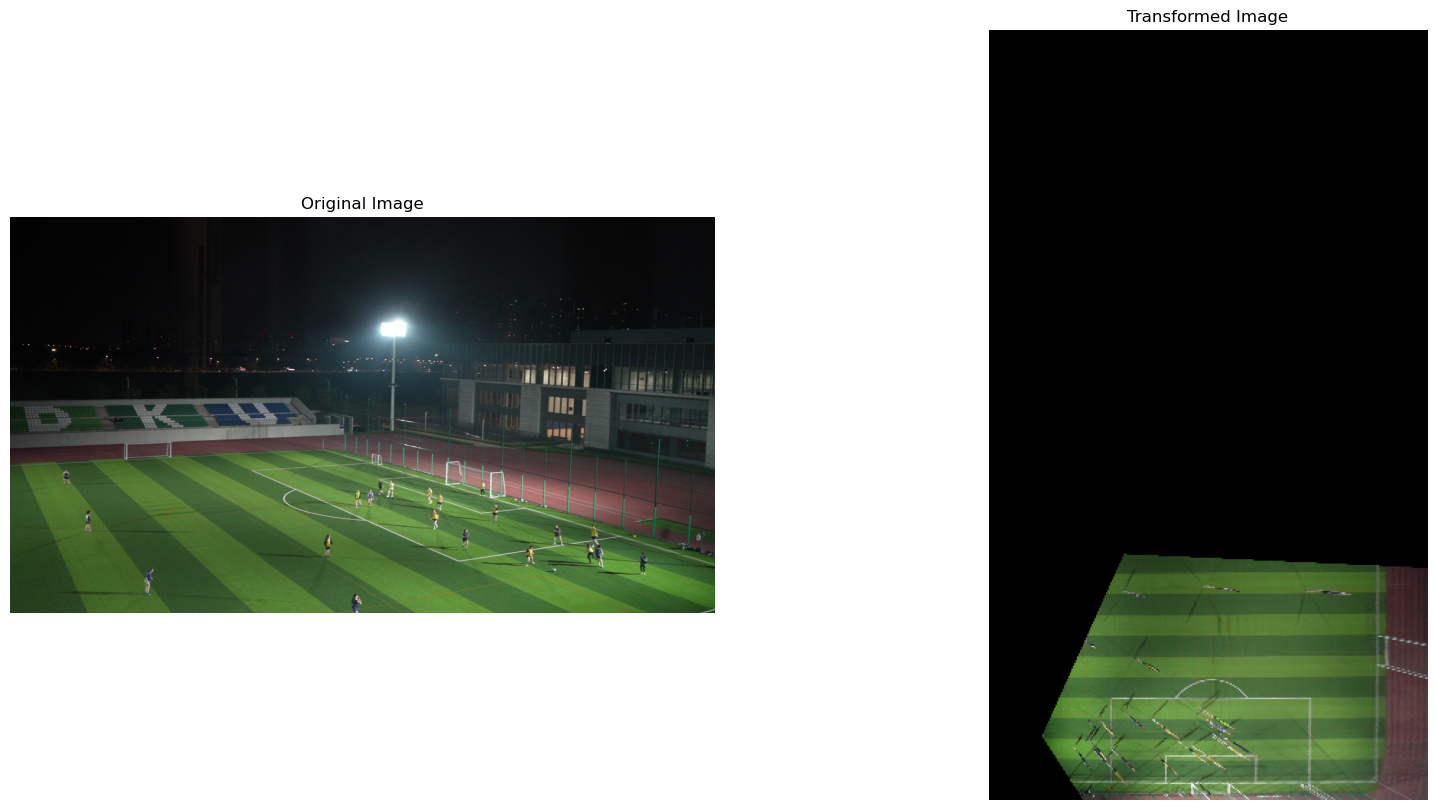

In [52]:
# Load the base map image
map_image_path = 'map.jpg'
base_map = cv2.imread(map_image_path)
if base_map is None:
    raise Exception(f"Map image {map_image_path} could not be loaded.")

height_of_map, width_of_map, _ = base_map.shape

# Apply the perspective transformation
transformed_image = cv2.warpPerspective(original_image, H, (width_of_map, height_of_map))

# Convert images from BGR to RGB
transformed_image_rgb = cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB)
original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Set the figure size in inches (width, height)
plt.figure(figsize=(20, 10))  # Increase width to accommodate both images side by side

# Display the original image
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.imshow(original_image_rgb)
plt.title('Original Image')
plt.axis('off')  # Hide the axes

# Display the transformed image
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.imshow(transformed_image_rgb)
plt.title('Transformed Image')
plt.axis('off')  # Hide the axes

# Save the figure
plt.savefig("homography.png", dpi=300, format='png', bbox_inches='tight', pad_inches=0.1)
# 'dpi=300' sets a high dots-per-inch (resolution)
# 'format=png' specifies the file format to use; PNG is lossless
# 'bbox_inches' and 'pad_inches' control the borders and padding around the saved figure

plt.show()


## Loading weights and setting labels depending on the model

In [53]:
# import torch

# # Load the YOLO model
# model = torch.load('weights/best_nafie.pt', map_location=torch.device('cpu'))
# print(model)

In [56]:
# Load the YOLOv8 players detection model
# change

# weight = "weights/best.pt"
# labels_dic = {
#     0:"player",
#     1:"referee",
#     2:"ball",
# }

# best_train is our own trained model
# best_nafie is found on: https://github.com/Mostafa-Nafie/Football-Object-Detection
# best is found on: https://github.com/MuhammadMoinFaisal/YOLOv8-DeepSORT-Object-Tracking
weight = "weights/best_train.pt"
labels_dic = {
    0:"Ball",
    1:"Player",
    2:"Ref",
}

model_players = YOLO(weight)

## Set Parameters

In [57]:
# Initialize frame counter
frame_nbr = 0

# Set confidence thresholds for players and field keypoints detections
player_model_conf_thresh = 0.30

# Set variable to record the time when we processed last frame 
prev_frame_time = 0
# Set variable to record the time at which we processed current frame 
new_frame_time = 0

# Store the ball track history
ball_track_history = {'src':[],
                      'dst':[]
}

# Count consecutive frames with no ball detected
nbr_frames_no_ball = 0
# Threshold for number of frames with no ball to reset ball track (frames)
nbr_frames_no_ball_thresh = 30
# Distance threshold for ball tracking (pixels)
ball_track_dist_thresh = 100
# Maximum ball track length (detections)
max_track_length = 35

# Initialize counters and storage for class detections
class_detection_counts = {}

## Choosing video and finding team colors

In [58]:
# change

# video_path = './videos/KVS_H1_TEST.mp4'
video_path = './videos/TrainingW_TEST.mp4'

tac_map = cv2.imread('./map.jpg')

#### K-means clustering

Grass BGR color:  (51.87859444151829, 105.67783926507104, 70.92713504935324)


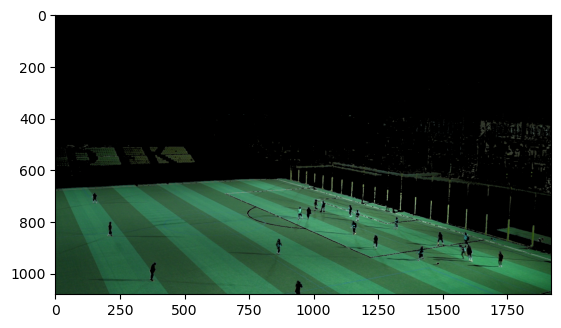

In [59]:
img = original_image
hsv = cv2.cvtColor(original_image, cv2.COLOR_BGR2HSV)

# Define a large range of green color in HSV
lower_green = np.array([30, 40, 40])
upper_green = np.array([80, 255, 255])

# Threshold the HSV image to get only green colors
mask = cv2.inRange(hsv, lower_green, upper_green)

# Calculate the mean value of the pixels that are not masked
masked_img = cv2.bitwise_and(img, img, mask=mask)
plt.imshow(masked_img)
grass_color = cv2.mean(img, mask=mask)
grass_color = grass_color[:3]
print("Grass BGR color: ", grass_color)

In [60]:
# Perform detection
results_players = model_players(img, conf=player_model_conf_thresh)

# Extract detection data
bboxes_p = results_players[0].boxes.xyxy.cpu().numpy() 
labels_p = list(results_players[0].boxes.cls.cpu().numpy())
confs_p = list(results_players[0].boxes.conf.cpu().numpy())

kits_colors = []
grass_hsv = cv2.cvtColor(np.uint8([[list(grass_color)]]), cv2.COLOR_BGR2HSV)

# Process each detection
for i, label in enumerate(labels_p):
    if label == 0:  # Assuming '0' is the label for players
        x1, y1, x2, y2 = map(int, bboxes_p[i])
        player_img = img[y1:y2, x1:x2]
        hsv = cv2.cvtColor(player_img, cv2.COLOR_BGR2HSV)

        # Adjust the green range based on the average grass color
        lower_green = np.array([grass_hsv[0, 0, 0] - 10, 40, 40])
        upper_green = np.array([grass_hsv[0, 0, 0] + 10, 255, 255])
        mask = cv2.inRange(hsv, lower_green, upper_green)
        mask = cv2.bitwise_not(mask)

        # Apply a mask to get the upper half of the player (typically where the kit is most visible)
        upper_mask = np.zeros(player_img.shape[:2], np.uint8)
        upper_mask[0:player_img.shape[0]//2, :] = 255
        mask = cv2.bitwise_and(mask, upper_mask)
        masked_img = cv2.bitwise_and(player_img, player_img, mask=mask)

        # Calculate the mean color of the player's kit
        player_kit_color = np.array(cv2.mean(player_img, mask=mask)[:3])
        kits_colors.append(player_kit_color)

        # Display results
        plt.imshow(cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Player Kit Color: {player_kit_color}")
        plt.show()


0: 416x736 20 players, 1 referee, 241.7ms
Speed: 4.9ms preprocess, 241.7ms inference, 7.5ms postprocess per image at shape (1, 3, 416, 736)


In [61]:
import numpy as np
from sklearn.cluster import KMeans
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

# Assuming kits_colors contains the BGR colors of the player kits extracted previously
kits_colors = np.array(kits_colors)

# Apply K-means clustering to classify the kits into two distinct colors
kits_kmeans = KMeans(n_clusters=2)
kits_kmeans.fit(kits_colors)

# Convert the BGR color format to RGB for visualization
kits_colors_rgb = kits_colors[:, [2, 1, 0]]  # Reversing BGR to RGB
cluster_centers_rgb = kits_kmeans.cluster_centers_[:, [2, 1, 0]]

# Create a 3D scatter plot of the kit colors
fig = px.scatter_3d(
    x=kits_colors_rgb[:, 0],
    y=kits_colors_rgb[:, 1],
    z=kits_colors_rgb[:, 2],
    range_x=[0, 255],
    range_y=[0, 255],
    range_z=[0, 255],
    title="Kits Colors Clustering",
    color=kits_kmeans.labels_
)

# Add the cluster centers to the plot
fig.add_scatter3d(
    x=cluster_centers_rgb[:, 0],
    y=cluster_centers_rgb[:, 1],
    z=cluster_centers_rgb[:, 2],
    mode='markers',
    marker=dict(color='black', size=10, symbol='cross'),
    name='Cluster Centers'
)

fig.show()

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [62]:
# Define team colors
nbr_team_colors = 2

In [63]:
# change
Team1 = "Team1"
Team2 = "Team2"

colors_dic = {
    f"{Team1}": [tuple(map(int, cluster_centers_rgb[0]))],  # Convert the first centroid to integer values
    f"{Team2}": [tuple(map(int, cluster_centers_rgb[1]))]   # Convert the second centroid to integer values
}

NameError: name 'cluster_centers_rgb' is not defined

#### Manual method

In [64]:
# change
Team1 = "Yellow"
Team2 = "Purple"
colors_dic = {
    "Purple":[(105,105,160), (105,105,160)], # DKU Colors (Players kit color, GK kit color)
    "Yellow":[(200,200,100), (200,200,100)] # KVS Colors (Players kit color, GK kit color)
}
# colors_list = colors_dic["Purple"]+colors_dic["Yellow"] # Define color list to be used for detected player team prediction

# colors_dic = {
#     "DKU":[(200,200,200), (115,144,98)], # DKU Colors (Players kit color, GK kit color)
#     "KVS":[(120,52,47), (47,103,43)] # KVS Colors (Players kit color, GK kit color)
# }


In [65]:
colors_list = colors_dic[f"{Team1}"]+colors_dic[f"{Team2}"] # Define color list to be used for detected player team prediction
color_list_lab = [skimage.color.rgb2lab([i/255 for i in c]) for c in colors_list] # Converting color_list to L*a*b* space

## Running the model

In [67]:
frame_save_path = 'saved_frames'
os.makedirs(frame_save_path, exist_ok=True)  # Create the directory if it doesn't exist

# Open video file
cap = cv2.VideoCapture(video_path)
tracker = sv.ByteTrack()
# Loop through the video frames
while cap.isOpened():

    # Read a frame from the video
    success, frame = cap.read()
    if not success:
        print("Failed to read frame or end of video reached.")
        break  # Exit the loop if no frame is read or end of video is reached

    frame = cv2.resize(frame, (window_width, window_height))

    # Save each frame to the folder
    frame_nbr += 1
    
    # Save number of detections per frame
    current_frame_class_counts = {}

    # Reset tactical map image for each new frame
    tac_map_copy = tac_map.copy()
    # Define the transparency factor (alpha)
    alpha = 0.5  # 50% transparency
    beta = (1.0 - alpha)  # Weight of the second array elements

    # Create a black background of the same size as the tactical map
    background = np.zeros_like(tac_map_copy)

    # Blend the tactical map with the black background
    tac_map_copy = cv2.addWeighted(tac_map_copy, alpha, background, beta, 0)

    # Reset ball tracks
    if nbr_frames_no_ball>nbr_frames_no_ball_thresh:
            ball_track_history['dst'] = []
            ball_track_history['src'] = []

    # Process the frame if it was successfuly read
    if success:
        
        #################### Part 1 ####################
        # Object Detection & Coordiante Transofrmation #
        ################################################

        # Run YOLOv8 players inference on the frame
        results_players = model_players(frame, conf=player_model_conf_thresh)
        detections = sv.Detections.from_ultralytics(results_players[0]) 
        detections = tracker.update_with_detections(detections)

        ## Extract detections information
        bboxes_p = results_players[0].boxes.xyxy.cpu().numpy()                # Detected players, referees and ball (x,y,x,y) bounding boxes
        bboxes_p_c = results_players[0].boxes.xywh.cpu().numpy()              # Detected players, referees and ball (x,y,w,h) bounding boxes    
        labels_p = list(results_players[0].boxes.cls.cpu().numpy())           # Detected players, referees and ball labels list
        confs_p = list(results_players[0].boxes.conf.cpu().numpy())           # Detected players, referees and ball confidence level

        # change
        bboxes_p_c_0 = bboxes_p_c[[i==1 for i in labels_p],:]                 # Get bounding boxes information (x,y,w,h) of detected players (label 0)
        bboxes_p_c_2 = bboxes_p_c[[i==0 for i in labels_p],:]                 # Get bounding boxes information (x,y,w,h) of detected ball(s) (label 2)
        # bboxes_p_c_0 = bboxes_p_c[[i==0 or i==1 or i==2 or i==3 for i in labels_p],:]  # Get bounding boxes information (x,y,w,h) of detected players (label 0)
        # bboxes_p_c_2 = bboxes_p_c[[i==4 for i in labels_p],:]                          # Get bounding boxes information (x,y,w,h) of detected ball(s) (label 2)

        # Get coordinates of detected players on frame (x_cencter, y_center+h/2)
        detected_ppos_src_pts = bboxes_p_c_0[:,:2]  + np.array([[0]*bboxes_p_c_0.shape[0], bboxes_p_c_0[:,3]/2]).transpose()
        # Get coordinates of the first detected ball (x_center, y_center)
        detected_ball_src_pos = bboxes_p_c_2[0,:2] if bboxes_p_c_2.shape[0]>0 else None

        # Transform players coordinates from frame plane to tactical map plance using the calculated Homography matrix
        pred_dst_pts = []                                                     # Initialize players tactical map coordiantes list
        for pt in detected_ppos_src_pts:     
            # print("Coor:", pt)
            pt = np.append(np.array(pt), np.array([1]), axis=0)               # Covert to homogeneous coordiantes
            dest_point = np.matmul(H, np.transpose(pt))                       # Apply homography transofrmation
            dest_point = dest_point/dest_point[2]           
            # print("map:", list(np.transpose(dest_point)[:2]))
            pred_dst_pts.append(list(np.transpose(dest_point)[:2]))           # Update players tactical map coordiantes list
        pred_dst_pts = np.array(pred_dst_pts)

        # Transform ball coordinates from frame plane to tactical map plane using the calculated Homography matrix
        if detected_ball_src_pos is not None:
            pt = np.append(np.array(detected_ball_src_pos), np.array([1]), axis=0)
            dest_point = np.matmul(H, np.transpose(pt))
            dest_point = dest_point/dest_point[2]
            detected_ball_dst_pos = np.transpose(dest_point)

            # Update track ball position history
            if len(ball_track_history['src'])>0 :
                if np.linalg.norm(detected_ball_src_pos-ball_track_history['src'][-1])<ball_track_dist_thresh:
                    ball_track_history['src'].append((int(detected_ball_src_pos[0]), int(detected_ball_src_pos[1])))
                    ball_track_history['dst'].append((int(detected_ball_dst_pos[0]), int(detected_ball_dst_pos[1])))
                else:
                    ball_track_history['src']=[(int(detected_ball_src_pos[0]), int(detected_ball_src_pos[1]))]
                    ball_track_history['dst']=[(int(detected_ball_dst_pos[0]), int(detected_ball_dst_pos[1]))]
            else:
                ball_track_history['src'].append((int(detected_ball_src_pos[0]), int(detected_ball_src_pos[1])))
                ball_track_history['dst'].append((int(detected_ball_dst_pos[0]), int(detected_ball_dst_pos[1])))
                
        # Remove oldest tracked ball postion if track exceedes threshold
        if len(ball_track_history) > max_track_length:
                ball_track_history['src'].pop(0)
                ball_track_history['dst'].pop(0)

        # After detection, populate the count for each detected class in the current frame
        for label in labels_p:
            if label in current_frame_class_counts:
                current_frame_class_counts[label] += 1
            else:
                current_frame_class_counts[label] = 1

        # Update the total detections for each class
        for label, count in current_frame_class_counts.items():
            if label in class_detection_counts:
                class_detection_counts[label] += count
            else:
                class_detection_counts[label] = count

        ######### Part 2 ########## 
        # Players Team Prediction #
        ###########################

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)                    # Convert frame to RGB
        obj_palette_list = []                                                 # Initialize players color palette list
        palette_interval = (0,5)                                              # Color interval to extract from dominant colors palette (1rd to 5th color)
        annotated_frame = frame                                               # Create annotated frame 

        ## Loop over detected players (label 0) and extract dominant colors palette based on defined interval
        for i, j in enumerate(list(results_players[0].boxes.cls.cpu().numpy())):
            # if int(j) == 0 or int(j) == 1 or int(j) == 2 or int(j) == 3:
            if int(j) == 1:
            # change
                bbox = results_players[0].boxes.xyxy.cpu().numpy()[i,:]                         # Get bbox info (x,y,x,y)
                obj_img = frame_rgb[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]       # Crop bbox out of the frame
                obj_img_w, obj_img_h = obj_img.shape[1], obj_img.shape[0]

                center_filter_x1 = np.max([(obj_img_w//2)-(obj_img_w//5), 1])
                center_filter_x2 = (obj_img_w//2)+(obj_img_w//5)
                center_filter_y1 = np.max([(obj_img_h//3)-(obj_img_h//5), 1])
                center_filter_y2 = (obj_img_h//3)+(obj_img_h//5)
                center_filter = obj_img[center_filter_y1:center_filter_y2, 
                                        center_filter_x1:center_filter_x2]

                # obj_pil_img = Image.fromarray(np.uint8(center_filter))                        # Convert to pillow image
                obj_pil_img = Image.fromarray(np.uint8(center_filter))                          # Convert to pillow image

                reduced = obj_pil_img.convert("P", palette=Image.Palette.WEB)                   # Convert to web palette (216 colors)
                palette = reduced.getpalette()                                                  # Get palette as [r,g,b,r,g,b,...]
                palette = [palette[3*n:3*n+3] for n in range(256)]                              # Group 3 by 3 = [[r,g,b],[r,g,b],...]
                color_count = [(n, palette[m]) for n,m in reduced.getcolors()]                  # Create list of palette colors with their frequency
                RGB_df = pd.DataFrame(color_count, columns = ['cnt', 'RGB']).sort_values(       # Create dataframe based on defined palette interval
                                      by = 'cnt', ascending = False).iloc[
                                          palette_interval[0]:palette_interval[1],:]
                palette = list(RGB_df.RGB)                                                      # Convert palette to list (for faster processing)
                annotated_frame = cv2.rectangle(annotated_frame,                                # Add center filter bbox annotations
                                                (int(bbox[0])+center_filter_x1, 
                                                 int(bbox[1])+ center_filter_y1),  
                                                (int(bbox[0])+center_filter_x2, 
                                                 int(bbox[1])+center_filter_y2), (0,0,0), 2)
                
                # Update detected players color palette list
                obj_palette_list.append(palette)
        
        ## Calculate distances between each color from every detected player color palette and the predefined teams colors
        players_distance_features = []
        # Loop over detected players extracted color palettes
        for palette in obj_palette_list:
            palette_distance = []
            palette_lab = [skimage.color.rgb2lab([i/255 for i in color]) for color in palette]  # Convert colors to L*a*b* space
            # Loop over colors in palette
            for color in palette_lab:
                distance_list = []
                # Loop over predefined list of teams colors
                for c in color_list_lab:
                    distance = skimage.color.deltaE_cie76(color, c)                             # Calculate Euclidean distance in Lab color space
                    distance_list.append(distance)                                              # Update distance list for current color
                palette_distance.append(distance_list)                                          # Update distance list for current palette
            players_distance_features.append(palette_distance)                                  # Update distance features list

        ## Predict detected players teams based on distance features
        players_teams_list = []
        # Loop over players distance features
        for distance_feats in players_distance_features:
            vote_list=[]
            # Loop over distances for each color 
            for dist_list in distance_feats:
                team_idx = dist_list.index(min(dist_list))//nbr_team_colors                     # Assign team index for current color based on min distance
                vote_list.append(team_idx)                                                      # Update vote voting list with current color team prediction
            players_teams_list.append(max(vote_list, key=vote_list.count))                      # Predict current player team by vote counting

        #################### Part 3 #####################
        # Updated Frame & Tactical Map With Annotations #
        #################################################

        ball_color_bgr = (0,0,255)                                                              # Color (GBR) for ball annotation on tactical map
        j=0                                                                                     # Initializing counter of detected players
        palette_box_size = 5                                                                    # Set color box size in pixels (for display)

        # Loop over all detected object by players detection model
        for i, tracker_id in zip(range(bboxes_p.shape[0]), detections.tracker_id):
            conf = confs_p[i]                                                                   # Get confidence of current detected object
            # change
            if labels_p[i]==1:                                                                  # Display annotation for detected players (label 0)
            # if labels_p[i]==0 or labels_p[i]==1 or labels_p[i]==2 or labels_p[i]==3:
                # Display extracted color palette for each detected player
                palette = obj_palette_list[j]                                                               # Get color palette of the detected player
                for k, c in enumerate(palette):
                    c_bgr = c[::-1]                                                                         # Convert color to BGR
                    annotated_frame = cv2.rectangle(annotated_frame, (int(bboxes_p[i,2])+3,                 # Add color palette annotation on frame
                                                            int(bboxes_p[i,1])+k*palette_box_size),
                                                            (int(bboxes_p[i,2])+palette_box_size,
                                                            int(bboxes_p[i,1])+(palette_box_size)*(k+1)),
                                                              c_bgr, -1)

                team_name = list(colors_dic.keys())[players_teams_list[j]]                                  # Get detected player team prediction
                color_rgb = colors_dic[team_name][0]                                                        # Get detected player team color
                color_bgr = color_rgb[::-1]                                                                 # Convert color to bgr

                annotated_frame = cv2.rectangle(annotated_frame, (int(bboxes_p[i,0]), int(bboxes_p[i,1])),  # Add bbox annotations with team colors
                                                (int(bboxes_p[i,2]), int(bboxes_p[i,3])), color_bgr, 1)
                # f" {conf:.2f}"
                cv2.putText(annotated_frame, f"#{tracker_id}" ,                                    # Add team name annotations
                             (int(bboxes_p[i,0]), int(bboxes_p[i,1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                               color_bgr, 2)
                
                if color_bgr == (255, 255, 255):
                    color_bgr = (0,0,0) 
                
                # Add tactical map player postion color coded annotation
                tac_map_copy = cv2.circle(tac_map_copy, (abs(int(pred_dst_pts[j][0])),abs(int(pred_dst_pts[j][1]))),
                                          radius=5, color=color_bgr , thickness=-1)          
                j+=1                                                                                        # Update players counter
                
            else:                                                                                            # Display annotation for other detections (label 1, 2)
                annotated_frame = cv2.rectangle(annotated_frame, (int(bboxes_p[i,0]), int(bboxes_p[i,1])),  
                                                 (int(bboxes_p[i,2]), int(bboxes_p[i,3])), (255,255,255), 4) # Add white colored bbox annotations
                cv2.putText(annotated_frame, labels_dic[int(labels_p[i])] + f" {conf:.2f}",
                            (int(bboxes_p[i,0]), int(bboxes_p[i,1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                              (255,255,255), 2)                                                              # Add white colored label text annotations
                print(labels_dic[int(labels_p[i])])
                # Add tactical map ball postion annotation if detected
                if detected_ball_src_pos is not None:
                    tac_map_copy = cv2.circle(tac_map_copy, (int(detected_ball_dst_pos[0]), 
                                                             int(detected_ball_dst_pos[1])), radius=5, 
                                                             color=ball_color_bgr, thickness=3)
        
        # Plot the ball tracks on tactical map
        if len(ball_track_history['src'])>0:
            points = np.hstack(ball_track_history['dst']).astype(np.int32).reshape((-1, 1, 2))
            tac_map_copy = cv2.polylines(tac_map_copy, [points], isClosed=False, color=(0, 0, 100), thickness=2)
        
        # Combine annotated frame and tactical map in one image with colored border separation
        border_color = [255,255,255]                                                                        # Set border color (BGR)
        annotated_frame=cv2.copyMakeBorder(annotated_frame, 40, 10, 10, 10,                                 # Add borders to annotated frame
                                            cv2.BORDER_CONSTANT, value=border_color)
        tac_map_copy = cv2.rotate(tac_map_copy, cv2.ROTATE_90_COUNTERCLOCKWISE)                             # 90 degrees rotation

        # Calculate the position to start the overlay (top right corner)
        start_y = 50
        start_x = annotated_frame.shape[1] - tac_map_copy.shape[1] - 50 # Start at the right edge of the annotated_frame

        annotated_frame[start_y:start_y + tac_map_copy.shape[0], start_x:start_x + tac_map_copy.shape[1]] = tac_map_copy

        final_img = annotated_frame

        ## Add info annotation
        cv2.putText(final_img, "Press 'p' to pause & 'q' to quit", (300,30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,0), 2)

        new_frame_time = time.time()                                                                        # Get time after finished processing current frame
        fps = 1/(new_frame_time-prev_frame_time)                                                            # Calculate FPS as 1/(frame proceesing duration)
        prev_frame_time = new_frame_time                                                                    # Save current time to be used in next frame
        cv2.putText(final_img, "FPS: " + str(int(fps)), (20,30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,0), 2)
        
        # Display the final annotated frame
        cv2.imshow("YOLOv8 Players and Field Keypoints Detection with Team Prediction and Tactical Map",    
                    final_img)
        
        frame_filename = os.path.join(frame_save_path, f'frame_{frame_nbr:04d}.jpg')
        cv2.imwrite(frame_filename, final_img)  # Save the frame as JPEG file

        # Treat keyboard user inputs ("p" for pause/unpause & "q" for quit)
        key = cv2.waitKey(1)
        # Break the loop if 'q' is pressed
        if key == ord("q"):
            break
        if key == ord('p'):
            cv2.waitKey(-1) #wait until any key is pressed
    else:
        # Break the loop if the end of the video is reached
        break

# Release the video capture object and close the display window
cap.release()
cv2.destroyAllWindows()


0: 416x736 19 players, 269.9ms
Speed: 3.4ms preprocess, 269.9ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 736)

0: 416x736 18 players, 213.8ms
Speed: 1.7ms preprocess, 213.8ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 736)

0: 416x736 18 players, 262.3ms
Speed: 1.4ms preprocess, 262.3ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 736)

0: 416x736 18 players, 261.9ms
Speed: 1.9ms preprocess, 261.9ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 736)

0: 416x736 18 players, 217.2ms
Speed: 1.7ms preprocess, 217.2ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 736)

0: 416x736 18 players, 241.1ms
Speed: 1.5ms preprocess, 241.1ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 736)

0: 416x736 18 players, 294.2ms
Speed: 1.8ms preprocess, 294.2ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 736)

0: 416x736 17 players, 217.6ms
Speed: 2.1ms preprocess, 217.6ms inference, 0.4ms postproc

In [43]:
# change

# Aggregate labels 0 to 3, safely handling missing labels
total_0_to_3 = sum(class_detection_counts.get(label, 0) for label in range(4))  # Use .get with default value 0
average_detections_per_class = {'0-3': total_0_to_3 / frame_nbr}  # Compute average for aggregated labels

# Compute average for label 4, safely handling cases where label might not be present
average_detections_per_class['4'] = class_detection_counts.get(4, 0) / frame_nbr

print("Average number of detections per class per frame:", average_detections_per_class)

# print("Average number of detections per class per frame:", 
#       class_detection_counts[0]/frame_nbr, 
#       class_detection_counts[1]/frame_nbr, 
      
#       )

Average number of detections per class per frame: {'0-3': 22.012832263978, '4': 0.0}


In [68]:
class_detection_counts

{1.0: 25354, 2.0: 259, 0.0: 4}

In [69]:
print(21240/frame_nbr)
print(2763/frame_nbr)

16.363636363636363
2.1286594761171034


In [70]:
import cv2
import os
import numpy as np

# Directory containing the frames
frame_folder = 'saved_frames'
# Output video file
output_video = 'output_video.avi'

# Get list of frame filenames in sorted order
frames = sorted([os.path.join(frame_folder, f) for f in os.listdir(frame_folder) if f.endswith(".jpg")])

# Determine the width and height from the first frame
frame = cv2.imread(frames[0])
height, width, layers = frame.shape

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'DIVX')  # Codec used for AVI files
video = cv2.VideoWriter(output_video, fourcc, 32.0, (width, height))

# Iterate through all the frames
for frame_path in frames:
    frame = cv2.imread(frame_path)
    video.write(frame)  # Write the frame to the video

# Release the video writer
video.release()

print("Video saved successfully!")


Video saved successfully!


: 